In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
import sklearn.gaussian_process as gp
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
import catboost as cb

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"]

plt.rcParams["axes.unicode_minus"]=False 

In [34]:
def data_load():
    data=pd.read_csv('./use_4.csv')
    train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
    feature=train_data.drop(['丙烯选择性'],axis=1)
    label=train_data['丙烯选择性']
    return feature,label,test_data

In [35]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)
log_param1 = [1e-2, 1e-1, 1.0, 10, 1e2]
log_param2 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
log_param3 = [1.0, 10, 1e2, 1e3, 1e4, 1e5]

In [36]:
model=['Catboost','Lasso','Ridge','GPR','SVR','RFR','ETR','XGB']
r2=[]
rmse=[]
feat, target ,test_data = data_load()

In [37]:
feat.drop(['Unnamed: 0'],axis=1,inplace=True)

In [38]:
feat

,Pt,Sn,W,Ni,Hf,V,Ti,Mg,BPO4,B,...,TiO2,Al2O3,CeO2,C2H6,C3H8,O2,保护气体,GHSV,温度,丙烷转化率
14,1.1,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,98.15,0.0,0.0,80.00,4.20,15.80,4760.0,600.0,15.2
70,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,2.44,2.44,95.12,18000.0,540.0,3.0
102,0.0,0.00,0.0,84.4,0.0,0.0,0.0,0.0,0.0,15.6,...,0.0,0.00,0.0,0.0,30.00,15.00,55.00,13645.0,500.0,6.1
213,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,16.70,16.70,66.60,21600.0,450.0,5.0
65,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,30.00,15.00,55.00,436364.0,550.0,9.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,23.00,15.00,62.00,3900.0,530.0,23.0
189,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,28.60,14.30,57.10,3600.0,400.0,7.5
138,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.00,0.0,0.0,15.00,5.00,80.00,46154.0,475.0,17.0
62,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,22.5,7.50,10.00,60.00,7000.0,500.0,41.0


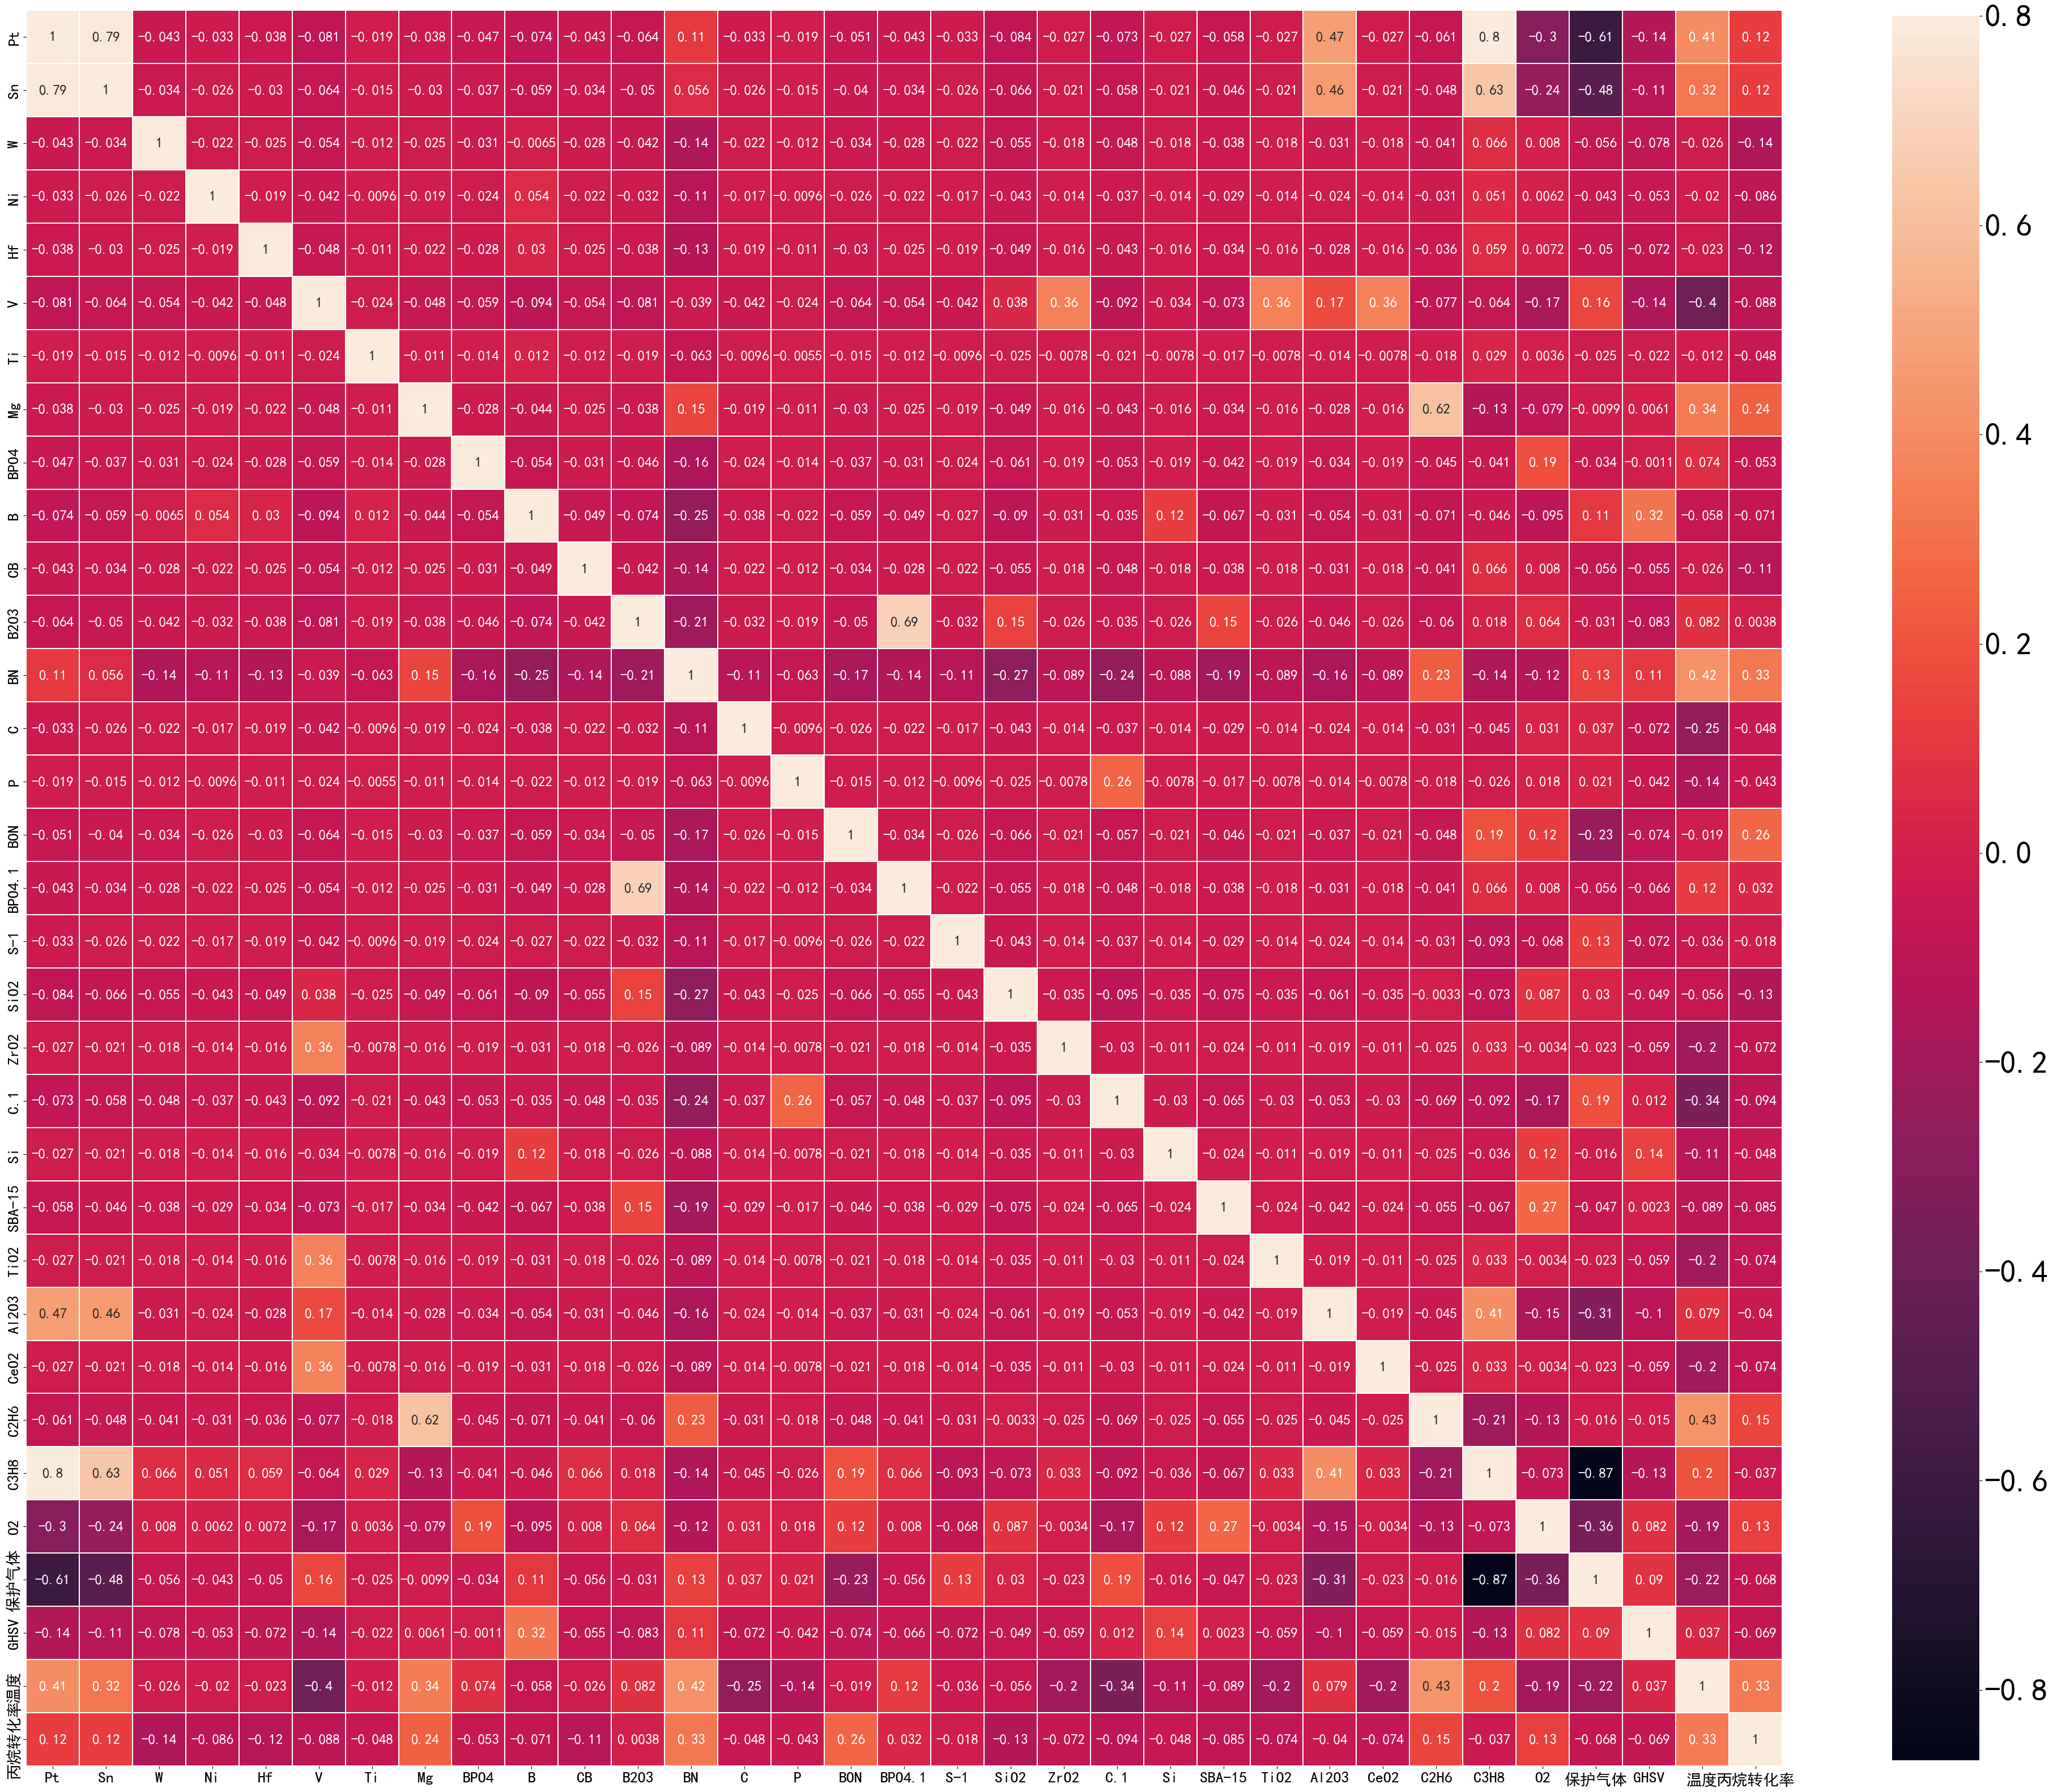

In [39]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(feat.corr(method='pearson'),linewidths=0.1,vmax=0.8, square=True,linecolor='white', 
            annot=True,annot_kws={'fontsize':18},cbar=True,cbar_kws={"shrink": 0.8})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('皮尔逊热力图',fontsize=80)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=40)
plt.show()

In [40]:
feat.corr(method='pearson')

,Pt,Sn,W,Ni,Hf,V,Ti,Mg,BPO4,B,...,TiO2,Al2O3,CeO2,C2H6,C3H8,O2,保护气体,GHSV,温度,丙烷转化率
Pt,1.000000,0.791098,-0.042628,-0.032835,-0.038021,-0.081434,-0.018852,-0.038021,-0.046829,-0.074395,...,-0.026735,0.468661,-0.026735,-0.061155,0.802561,-0.302229,-0.611718,-0.135280,0.408079,0.122803
Sn,0.791098,1.000000,-0.033723,-0.025975,-0.030078,-0.064422,-0.014914,-0.030078,-0.037047,-0.058854,...,-0.021150,0.460430,-0.021150,-0.048380,0.634904,-0.239093,-0.483929,-0.107020,0.322830,0.123128
W,-0.042628,-0.033723,1.000000,-0.021759,-0.025195,-0.053964,-0.012493,-0.025195,-0.031033,-0.006472,...,-0.017716,-0.031032,-0.017716,-0.040526,0.065807,0.008031,-0.055670,-0.077638,-0.026244,-0.144109
Ni,-0.032835,-0.025975,-0.021759,1.000000,-0.019407,-0.041566,-0.009623,-0.019407,-0.023903,0.053922,...,-0.013646,-0.023903,-0.013646,-0.031215,0.050688,0.006186,-0.042880,-0.052670,-0.020214,-0.086318
Hf,-0.038021,-0.030078,-0.025195,-0.019407,1.000000,-0.048131,-0.011142,-0.022472,-0.027678,0.029697,...,-0.015802,-0.027678,-0.015802,-0.036146,0.058694,0.007163,-0.049653,-0.072225,-0.023407,-0.116360
V,-0.081434,-0.064422,-0.053964,-0.041566,-0.048131,1.000000,-0.023865,-0.048131,-0.059282,-0.094179,...,0.363554,0.173688,0.363554,-0.077418,-0.064496,-0.165515,0.159351,-0.142395,-0.404799,-0.087800
Ti,-0.018852,-0.014914,-0.012493,-0.009623,-0.011142,-0.023865,1.000000,-0.011142,-0.013724,0.012357,...,-0.007835,-0.013724,-0.007835,-0.017922,0.029103,0.003552,-0.024620,-0.022438,-0.011606,-0.048437
Mg,-0.038021,-0.030078,-0.025195,-0.019407,-0.022472,-0.048131,-0.011142,1.000000,-0.027678,-0.043971,...,-0.015802,-0.027678,-0.015802,0.621705,-0.128352,-0.078853,-0.009870,0.006149,0.340419,0.242280
BPO4,-0.046829,-0.037047,-0.031033,-0.023903,-0.027678,-0.059282,-0.013724,-0.027678,1.000000,-0.054158,...,-0.019462,-0.034091,-0.019462,-0.044520,-0.041192,0.185396,-0.034207,-0.001135,0.074373,-0.052822
B,-0.074395,-0.058854,-0.006472,0.053922,0.029697,-0.094179,0.012357,-0.043971,-0.054158,1.000000,...,-0.030919,-0.054158,-0.030919,-0.070727,-0.045630,-0.094623,0.106685,0.317980,-0.057862,-0.071215


In [41]:
# CatBoost
cvmodel = GridSearchCV(cb.CatBoostRegressor(random_state=1314,iterations=190,silent=True,learning_rate=0.1),
                       param_grid={'depth':[1,10]},
                       n_jobs = -1)
print('Catboost:')
r2.append(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='r2').mean())
rmse.append(pow(abs(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5))
print('r2:',r2[-1])
print('rmse:',rmse[-1])
print('----------------')

Catboost:
r2: 0.6947925373227678
rmse: 11.258385730917867
----------------


In [42]:
#Lasso
cvmodel = GridSearchCV(Lasso(),
                        param_grid = {'alpha': log_param1},
                        n_jobs = -1)
print('Lasso:')
r2.append(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='r2').mean())
rmse.append(pow(abs(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5))
print('r2:',r2[-1])
print('rmse:',rmse[-1])
print('----------------')


Lasso:
r2: 0.5655012959057852
rmse: 13.991872455129952
----------------


In [43]:
#Ridge
cvmodel = GridSearchCV(Ridge(),
                        param_grid = {'alpha': log_param1},
                        n_jobs = -1)
print('Ridge:')
r2.append(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='r2').mean())
rmse.append(pow(abs(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5))
print('r2:',r2[-1])
print('rmse:',rmse[-1])
print('----------------')

Ridge:
r2: 0.5551330107340903
rmse: 14.118010211466473
----------------


In [44]:
#GPR
kernel = gp.kernels.Matern(nu = 2.5)
cvmodel = GridSearchCV(gp.GaussianProcessRegressor(kernel = kernel,
                                                    normalize_y = True,
                                                    n_restarts_optimizer = 10,
                                                    random_state = 1314),
                        param_grid = {'alpha':log_param2},
                        n_jobs = -1)
print('GPR:')
r2.append(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='r2').mean())
rmse.append(pow(abs(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5))
print('r2:',r2[-1])
print('rmse:',rmse[-1])
print('----------------')

GPR:
r2: 0.2013006753323458
rmse: 18.206656140306205
----------------


In [45]:

#SVR
cvmodel = GridSearchCV(SVR(kernel = 'rbf'),
                        param_grid = {'C': log_param3,
                                        'gamma':log_param2,
                                        'epsilon':log_param1},
                        n_jobs = -1)
print('SVR:')
r2.append(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='r2').mean())
rmse.append(pow(abs(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5))
print('r2:',r2[-1])
print('rmse:',rmse[-1])
print('----------------')

SVR:
r2: 0.5585305136589919
rmse: 13.675866543920161
----------------


In [46]:

#RFR
cvmodel = GridSearchCV(RandomForestRegressor(n_jobs = -1, random_state = 1314),
                        param_grid = {'n_estimators':[500, 1000]},
                        n_jobs = -1)
print('RFR:')
r2.append(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='r2').mean())
rmse.append(pow(abs(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5))
print('r2:',r2[-1])
print('rmse:',rmse[-1])
print('----------------')

RFR:
r2: 0.6873475362726745
rmse: 11.927383070382817
----------------


In [47]:

#ETR
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1314),
                        param_grid = {'n_estimators':[500, 1000]},
                        n_jobs = -1)
print('ETR:')
r2.append(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='r2').mean())
rmse.append(pow(abs(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5))
print('r2:',r2[-1])
print('rmse:',rmse[-1])
print('----------------')

ETR:
r2: 0.7020784277123362
rmse: 11.31270521304397
----------------


In [48]:

#XGB
cvmodel = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 1314,subsample=0.38,learning_rate=0.1),
                        param_grid = {'n_estimators':[300, 500],'max_depth':[2,3,4,5,6,7,8,9,10]},
                        n_jobs = -1)
print('XGB:')
r2.append(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='r2').mean())
rmse.append(pow(abs(cross_val_score(estimator=cvmodel,X=feat, y=target, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5))
print('r2:',r2[-1])
print('rmse:',rmse[-1])
print('----------------')

XGB:
r2: 0.6448456753599535
rmse: 11.855597657067802
----------------


In [49]:
model=['Catboost','Lasso','Ridge','GPR','SVR','RFR','ETR','XGB']
c={'model' : model,
   'R2' : r2,
   'RMSE' : rmse
   }
final=pd.DataFrame(c)
final

,model,R2,RMSE
0,Catboost,0.694793,11.258386
1,Lasso,0.565501,13.991872
2,Ridge,0.555133,14.118010
3,GPR,0.201301,18.206656
4,SVR,0.558531,13.675867
5,RFR,0.687348,11.927383
6,ETR,0.702078,11.312705
7,XGB,0.644846,11.855598


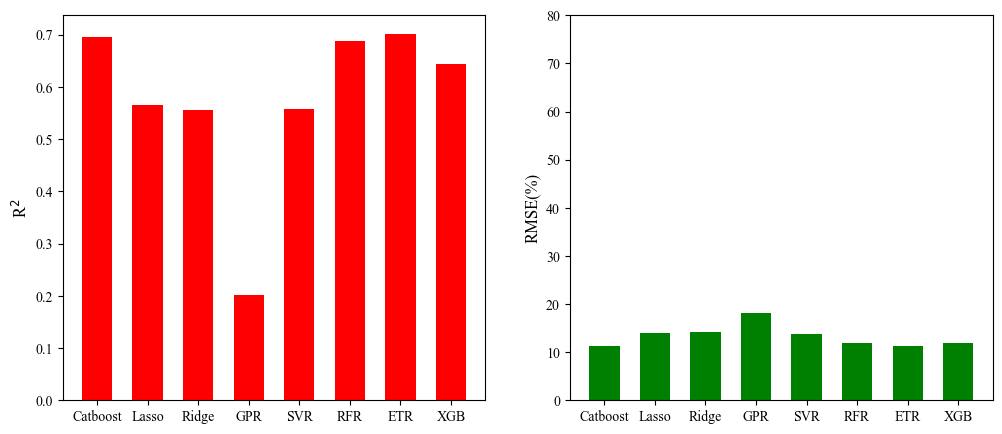

In [81]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
# fig.suptitle('硼基催化剂中中各个模型拟合效果评估',y=0)

axs[0].bar(final.iloc[:,0],final.iloc[:,1],width=0.6,fc='r')
axs[0].set_ylabel('R$^2$',font=Path('..\TimesNewRoman.ttf'),fontsize=12)
x1_label = axs[0].get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = axs[0].get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
axs[1].bar(final.iloc[:,0],final.iloc[:,2],width=0.6,fc='g')
axs[1].set_ylabel('RMSE(%)',font=Path('..\TimesNewRoman.ttf'),fontsize=12)
x2_label = axs[1].get_xticklabels() 
[x2_label_temp.set_fontname('Times New Roman') for x2_label_temp in x2_label]
y2_label = axs[1].get_yticklabels() 
[y2_label_temp.set_fontname('Times New Roman') for y2_label_temp in y2_label]
axs[1].set_ylim(0,80)
plt.show()